<div style="font-family: 'Georgia', serif; border-left: 3px solid #ccc; padding-left: 12px; margin-bottom: 1em;">
  <h2 style="margin: 0; color: #EF8C00; font-size: 2.4em; padding-left: 0; text-indent: 0;">
      Artistic Speech Analysis
  </h2>
    <p>
        pitch; loudness; praat-parselmouth;
    </p>
</div>

## Plan of Action
- Manually label a few audio clips of poem recitation.
- Extract few relevant audio features to make initial observations.
- Plan things accordingly.

In [155]:
import modusa as ms
import numpy as np
import librosa
import parselmouth
from scipy.interpolate import interp1d

In [ ]:
# Load the recitation audio 1
y1, y1_sr, y1_title = ms.load("../../../data/speech_fsm/this_is_me_02.wav", sr=16000)
y1_t = np.arange(y1.size) / y1_sr
y1_ann = ms.load_ann("../../../data/speech_fsm/this_is_me_02_labels.txt")

# Load the recitation audio 2
y2, y2_sr, y2_title = ms.load("https://www.youtube.com/watch?v=2bNXb35K8TA", sr=16000)
y2 = y2[int(24 * y2_sr):int(64 * y2_sr)] # Trim region where the poem is performed
y2_t = np.arange(y2.size) / y2_sr
y2_ann = None

In [340]:
display(ms.play(y1, y1_sr, title=y1_title))
display(ms.play(y2, y2_sr, title=y2_title))

## Computing pitch and intensity contour

Now we compute acoustic features like `intensity` and `pitch`. We will use `praat-parselmouth` for this.

In [341]:
# Helper functions
def get_mag_spec(y, n_fft, win_length, hop_length):
    """
    Compute spectrogram.

    Parameters
    ----------
    y: ndarray
        Signal.
    n_fft: int
        Number of fft bins (samples).
    win_length: int
        Window length (samples).
    hop_length: int
        Hop length (samples).
        
    Returns
    -------
    ndarray
        2D spectrogram matrix.
    ndarray
        1D frequency axis.
    ndarray
        1D time axis.
    """    
    S = librosa.stft(y=y, n_fft=N, win_length=N, hop_length=H, center=True, window="hann")
    S = np.abs(S) # Magnitude spectrum
    S_fr = y_sr / H # Frame rate (Hz)
    S_f = np.arange(S.shape[0]) * (y_sr / N)
    S_t = np.arange(S.shape[1]) / S_fr

    return S, S_f, S_t

def get_pitch_contour(y, sr, in_midi=False):
    """
    Compute pitch contour using autocorrelation method from Praat.

    Parameters
    ----------
    y: ndarray
       Audio signal.
    sr: int
        Sampling rate of the audio signal.

    Returns
    -------
    ndarray
        Pitch contour array.
    ndarray
        Timestamp (sec).
    """
    time_step = 0.01
    
    snd = parselmouth.Sound(values=y, sampling_frequency=sr)
    pitch_obj = snd.to_pitch_ac(
        time_step=time_step,
        pitch_floor=75.0, 
        max_number_of_candidates=15, 
        very_accurate=False, 
        silence_threshold=0.01,
        voicing_threshold=0.35, 
        octave_cost=0.05, 
        octave_jump_cost=0.35, 
        voiced_unvoiced_cost=0.4, 
        pitch_ceiling=600
    )
    f0 = pitch_obj.selected_array['frequency']
    f0_t = pitch_obj.ts()

    if in_midi is True:
        mask = f0 > 0
        f0[mask] = librosa.hz_to_midi(f0[mask])
    return f0, f0_t


def get_intensity_contour(y, sr):
    """
    Compute intensity contour with Praat.

    Parameters
    ----------
    y: ndarray
       Audio signal.
    sr: int
        Sampling rate of the audio signal.

    Returns
    -------
    ndarray
        Intensity contour array.
    ndarray
        Timestamp (sec).
    """
    # Parameters
    time_step=0.01
    minimum_pitch=75.0
    
    snd = parselmouth.Sound(values=y, sampling_frequency=sr)
    intensity_obj = snd.to_intensity(minimum_pitch=minimum_pitch, time_step=time_step, subtract_mean=True)
    I = intensity_obj.values[0]
    I[I<0] = 0
    I_t = intensity_obj.ts()
    return I, I_t

In [342]:
#========1=========
# Spectrogram
N, H = 1024, 160 # 64ms, 10ms
S1, S1_f, S1_t = get_mag_spec(y1, n_fft=N, win_length=N, hop_length=H)

# Pitch information
fo1, fo1_t = get_pitch_contour(y1, y1_sr, in_midi=True)
fo1 = interp1d(fo1_t, fo1, fill_value="extrapolate")(S1_t)
fo1_t = S1_t.copy()

# Intensity information
I1, I1_t = get_intensity_contour(y1, y1_sr)
I1 = interp1d(I1_t, I1, fill_value="extrapolate")(S1_t)
I1_t = S1_t.copy()

#========2=========
# Spectrogram
N, H = 1024, 160 # 64ms, 10ms
S2, S2_f, S2_t = get_mag_spec(y2, n_fft=N, win_length=N, hop_length=H)

# Pitch information
fo2, fo2_t = get_pitch_contour(y2, y2_sr, in_midi=True)
fo2 = interp1d(fo2_t, fo2, fill_value="extrapolate")(S2_t)
fo2_t = S2_t.copy()

# Intensity information
I2, I2_t = get_intensity_contour(y2, y2_sr)
I2 = interp1d(I2_t, I2, fill_value="extrapolate")(S2_t)
I2_t = S2_t.copy()

# We have kept timestep to be 10ms for praat which is same as what we set while computing stft with librosa but
# Praat internally handles the window size which makes the timestamps misaligned, we need to interpolate the values
# at consistent timestamps

### Visualisation

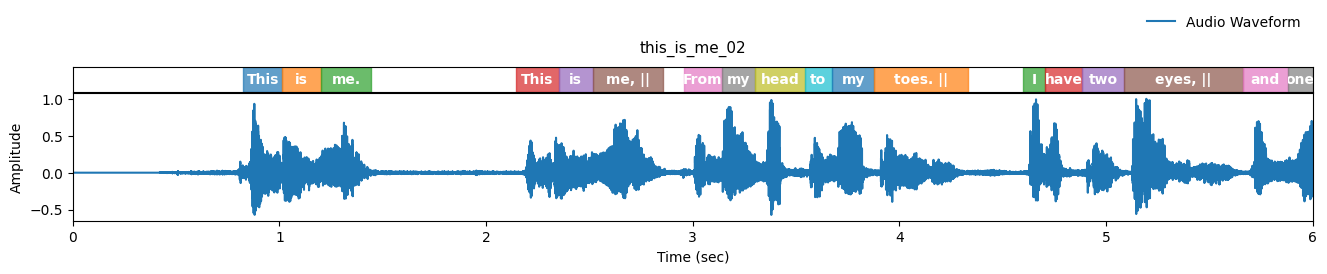

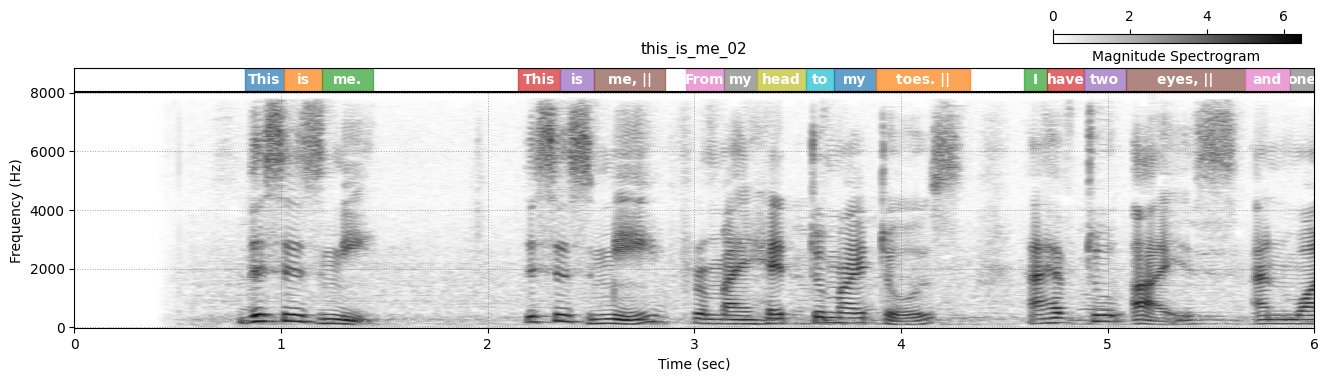

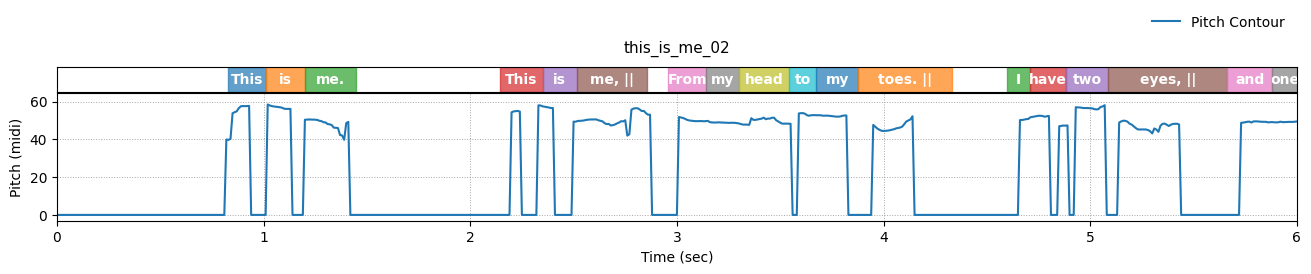

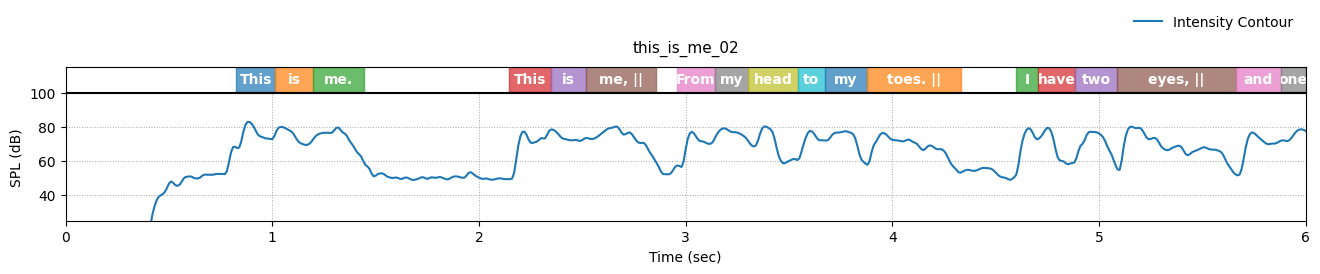

In [351]:
xlim = (0, 6)

display(ms.plot1d(
    (y1, np.arange(y1.size) / y1_sr),
    ann=y1_ann,
    title=y1_title,
    ylabel="Amplitude",
    xlabel="Time (sec)",
    legend="Audio Waveform",
    xlim=xlim,
    
))

display(ms.plot2d(
    (np.log(1+10*S1), S1_f, S1_t),
    ann=y1_ann,
    title=y1_title,
    Mlabel="Magnitude Spectrogram",
    ylabel="Frequency (Hz)",
    xlabel="Time (sec)",
    xlim=xlim,
    show_grid=True
))

display(ms.plot1d(
    (fo1, fo1_t),
    ann=y1_ann,
    title=y1_title,
    ylabel="Pitch (midi)",
    xlabel="Time (sec)",
    legend="Pitch Contour",
    xlim=xlim,
    show_grid=True
))

display(ms.plot1d(
    (I1, I1_t),
    ann=y1_ann,
    title=y1_title,
    ylabel="SPL (dB)",
    xlabel="Time (sec)",
    legend="Intensity Contour",
    xlim=xlim,
    ylim=(25, 100),
    show_grid=True
))

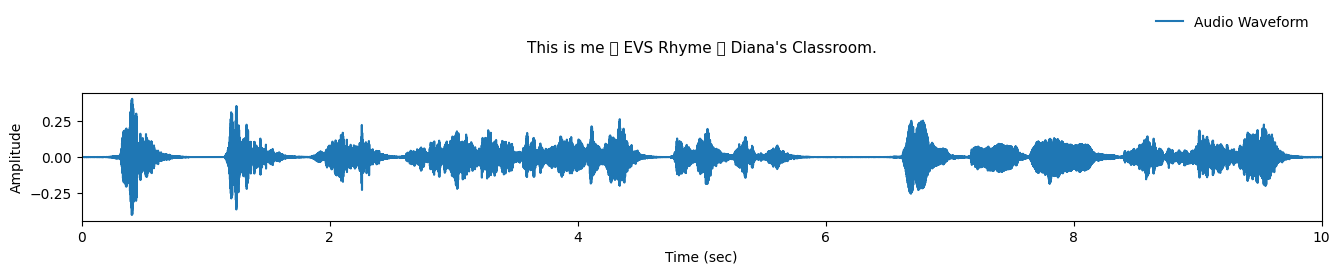

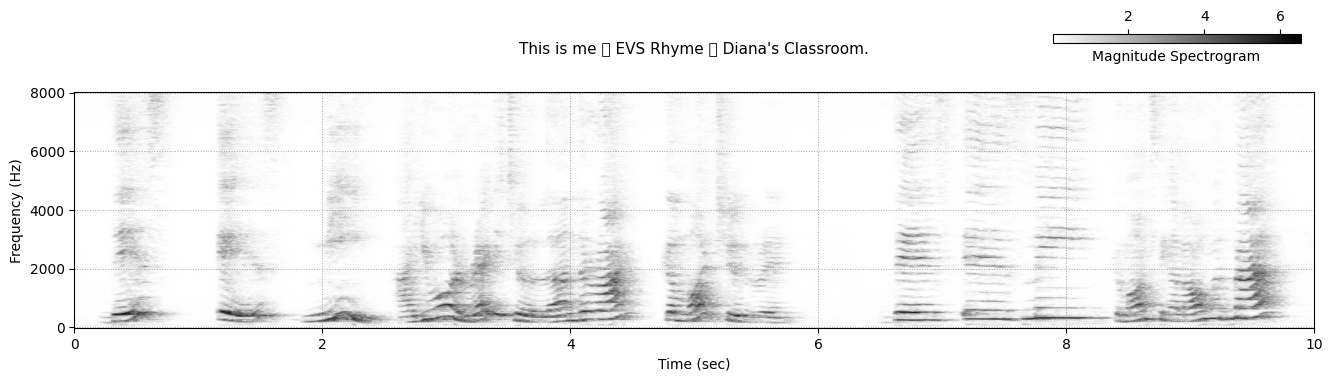

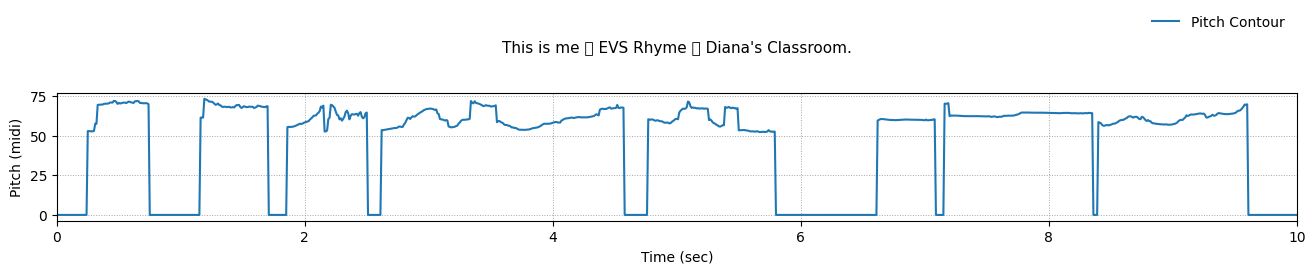

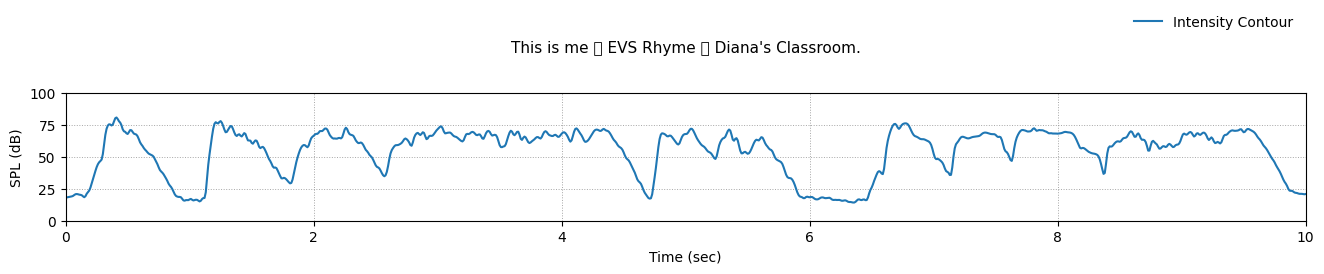

In [350]:
xlim = (0, 10)

display(ms.plot1d(
    (y2, np.arange(y2.size) / y2_sr),
    ann=y2_ann,
    title=y2_title,
    ylabel="Amplitude",
    xlabel="Time (sec)",
    legend="Audio Waveform",
    xlim=xlim,
    
))

display(ms.plot2d(
    (np.log(1+10*S2), S2_f, S2_t),
    ann=y2_ann,
    title=y2_title,
    Mlabel="Magnitude Spectrogram",
    ylabel="Frequency (Hz)",
    xlabel="Time (sec)",
    xlim=xlim,
    show_grid=True
))

display(ms.plot1d(
    (fo2, fo2_t),
    ann=y2_ann,
    title=y2_title,
    ylabel="Pitch (midi)",
    xlabel="Time (sec)",
    legend="Pitch Contour",
    xlim=xlim,
    show_grid=True
))

display(ms.plot1d(
    (I2, I2_t),
    ann=y2_ann,
    title=y2_title,
    ylabel="SPL (dB)",
    xlabel="Time (sec)",
    legend="Intensity Contour",
    xlim=xlim,
    ylim=(0, 100),
    show_grid=True
))

## Some ideas to try out
- We can look at pitch changes of model readers' delivery. In case we find that the pitch dynamics ranges with musical note or sub-note level, we can try to encode the reference markers in unit of musical notation. Such representation will be user friendly and can be learned with existing musical frameworks.
- 

## Acoustic features distribution

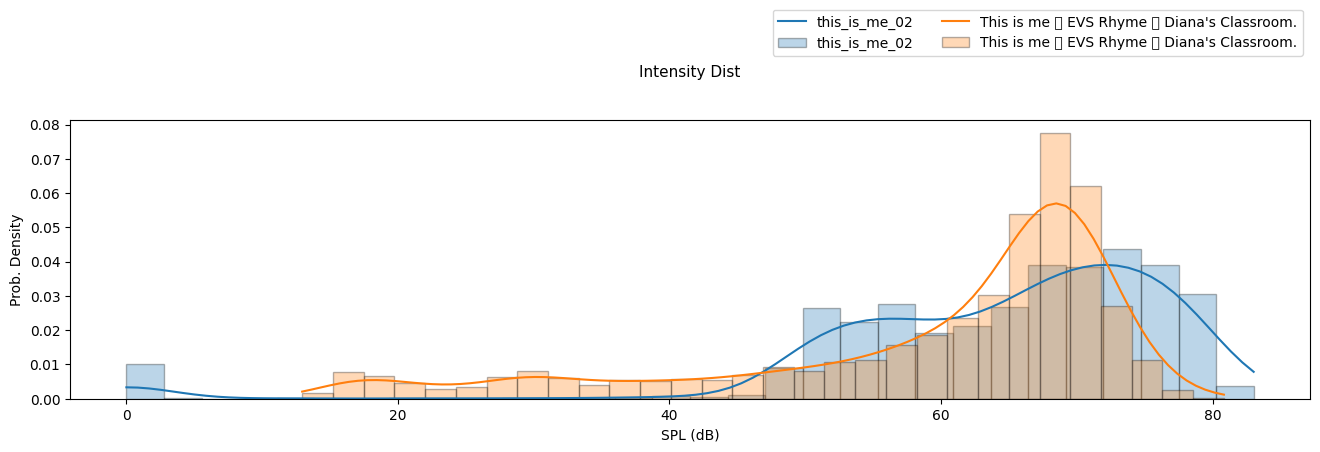

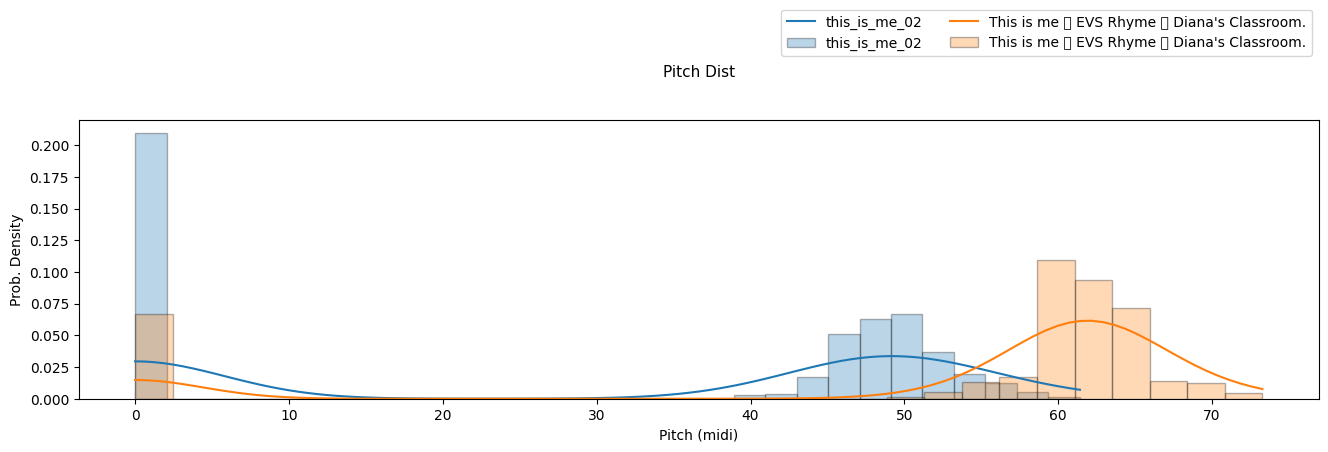

In [346]:
display(ms.plot_dist(I1, I2, xlabel="SPL (dB)", ylabel="Prob. Density", legend=[y1_title, y2_title], npoints=100, bins=30, title="Intensity Dist"))

display(ms.plot_dist(fo1, fo2, xlabel="Pitch (midi)", ylabel="Prob. Density", legend=[y1_title, y2_title], npoints=100, bins=30, title="Pitch Dist"))